# Sample Size Calculator

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
from statsmodels.stats.power import TTestIndPower


# Two Sample T Test

In [21]:
# parameters for power analysis
effect = 0.1
alpha = 0.05
power = 0.8

#effect is Cohen D where var.mean - control.mean / std
#ratio = 1.0 since samples is the same size

# perform power analysis
analysis = TTestIndPower()

#whichever the parameter is None then that is what the result will return
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 1570.733


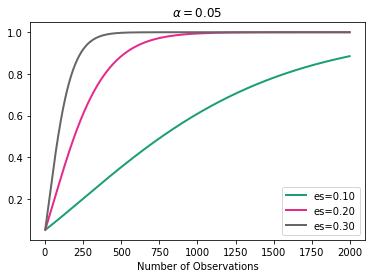

In [23]:
# power vs. number of observations 

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 2000),
                                 effect_size=np.array([0.1, 0.2, 0.3]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 

In [ ]:
#resource link
#https://www.houseofbots.com/news-detail/4145-1-an-amazing-introduction-to-power-analysis-in-python

# Two Sample Z Test

In [24]:
#Two proportion Z test function

def compute_sample_size(prop1, min_diff, significance = 0.05, power = 0.8):
    """
    Computes the sample sized required for a two-proportion A/B test;
    result matches R's pwr.2p.test from the pwr package
    
    Parameters
    ----------
    prop1 : float
        The baseline proportion, e.g. conversion rate 
        
    min_diff : float
        Minimum detectable difference; relative lift
        
    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95
    
    power : float, default 0.8
        Often denoted as beta. Power of 0.80 means that there is an 80%
        chance that if there was an effect, we would detect it
        (or a 20% chance that we'd miss the effect)
        
    Returns
    -------
    sample_size : int
        Required sample size for each group of the experiment

    References
    ----------
    R pwr package's vignette
    - https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html

    Stackoverflow: Is there a python (scipy) function to determine parameters
    needed to obtain a target power?
    - https://stackoverflow.com/questions/15204070/is-there-a-python-scipy-function-to-determine-parameters-needed-to-obtain-a-ta
    """
    prop2 = prop1 + min_diff
    effect_size = sms.proportion_effectsize(prop1, prop2)
    sample_size = sms.NormalIndPower().solve_power(
        effect_size, power = power, alpha = significance, ratio = 1)
    
    return sample_size

In [26]:
#Function use
sample_size = compute_sample_size(prop1 = 0.1, min_diff = 0.02)
print('sample size required per group:', sample_size)

sample size required per group: 3834.595739884031


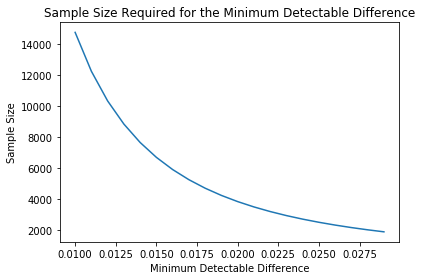

In [4]:
#Graph for sample  size
# calculate the the required sample size
# for a range of minimum detectable difference
sample_sizes = []
min_diffs = np.arange(0.01, 0.03, 0.001) #to grab min dectable from  0.1 pct pts to 0.3%
for min_diff in min_diffs:
    sample_size = compute_sample_size(prop1 = 0.1, min_diff = min_diff)
    sample_sizes.append(sample_size)

plt.plot(min_diffs, sample_sizes)
plt.title('Sample Size Required for the Minimum Detectable Difference')
plt.ylabel('Sample Size')
plt.xlabel('Minimum Detectable Difference')
plt.tight_layout()
plt.show()

# Two Sample Z Test v2

In [7]:
#p1 proportion of control, n1 size of control
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [8]:
#sample size for z two propotion test
#p1 propotion for control
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

In [9]:
p_diffs = [x*.01 for x in range(2,11)]

data = []
for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial probability'] = '50%'
    data.append(record)

for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.01)
    record['Confidence Level'] = '99%'
    record['Initial probability'] = '50%'
    data.append(record)

df = pd.DataFrame(data)

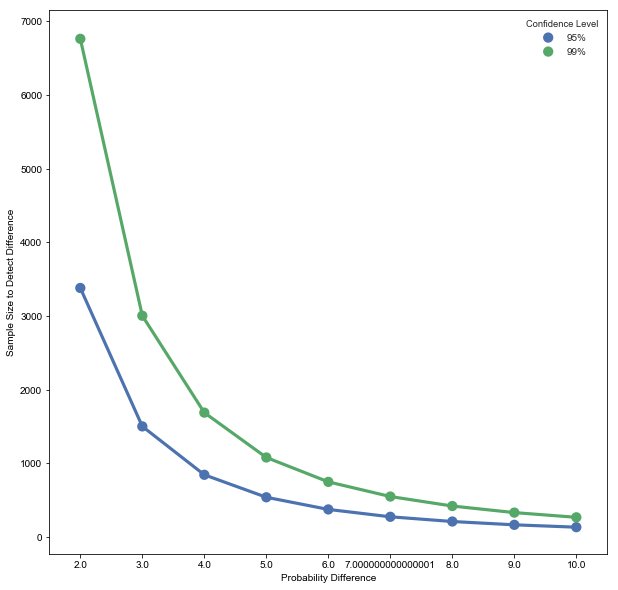

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.set(style='darkgrid')

plot = sns.pointplot(x='Probability Difference',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)
plt.show()
#total sample so control + variation = total

# Two Sample Z Test v3

In [ ]:
#power function
from scipy import stats
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2-p1)
    bp = (p1+p2) / 2
    
    v1 = p1 * (1-p1)
    v2 = p2 * (1-p2)
    bv = bp * (1-bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    
    power = power_part_one + power_part_two
    
    return (power)

In [ ]:
def get_sample_size(power, p1, p2, cl, max_n=1000000):
    n = 1 
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)
if tmp_power >= power: 
            return n 
        else: 
            n = n + 100
return "Increase Max N Value"

#https://medium.com/@henryfeng/handy-functions-for-a-b-testing-in-python-f6fdff892a90

In [ ]:
#https://github.com/CloudChaoszero/Presentations/blob/master/PyBayTalks/2019/AB-Testing-Python/Code/0-ABTesting-Presentation-2019.ipynb

# My Function for Sample Size Calculator

## Inputs

In [11]:
#Unit of measurement per day: unique visitors, sessions, or hits (int)  
units_per_day =  30000 

#What % of the population will see the variation? (float 0.01 - 0.99) Ex. 0.01 = 1.00%
var_perc = 0.50

#What is the control conversion rate? (float 0.01 - 0.99) Ex. 0.01 = 1.00%
cont_conv_rate =  0.02

#What is the minimum relative percetange change to control convversion rate? (float 0.01 - 0.99) Ex. 0.01 = 1.00% so variation is 2.02% vs 2.00%
mde = 0.01

#What is the significance level? (float 0.01 - 0.10) Ex. 0.05 = 5% signficance 
# p-value needs to be below signifance level to be significant
# alpha is the percentage of a false positive
alpha = 0.05

#What is the power level of correctly rejecting the null hypothesis? (float 0.70.00 - 0.99) Ex. 0.80 = 80% 
#If power is 0.8 then beta (false negative rate, fail to reject the null when we should) is 20%
power = 0.80 

#Is it a two-tailed or one-tailed test?
two_tail = True

#Is it aa two sample or one sample  test?
two_sample = True

#Is it a t distribution or z distribution?
#list of distribution: ['t_distribution', 'z_distribution', 'chi2_distribution']
distribution = 't_distribution'

In [ ]:
def calculate_sample_size(units_per_day, var_perc, cont_conv_rate, mde, alpha, power, two_tail, two_sample, distribution):
    #Calculate variance conversion rate 
    var_conv_rate = cont_conv_rate * (1 + mde)
    cont_size_per_day = units_per_day * (1 - var_perc)
    var_size_per_day = units_per_day * var_perc
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [12]:
var_conv_rate = cont_conv_rate * (1 + mde)
print(var_conv_rate)

0.0202


In [14]:
cont_size_per_day = units_per_day * (1 - var_perc)
var_size_per_day = units_per_day * var_perc
print('Control size per day: {0} Variation size per day: {1}'.format(cont_size_per_day, var_size_per_day))

Control size per day: 15000.0 Variation size per day: 15000.0


In [ ]:
#https://www.statsmodels.org/stable/_modules/statsmodels/stats/power.html#TTestIndPower

In [5]:
get_power(100, 0.05, 0.055, 0.95)

0.05273384989671647